In [1]:
import os
import pandas as pd
from os.path import join
import cv2
import numpy as np
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ELU
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Activation, UpSampling2D
from keras.optimizers import SGD
import keras.backend as K
from skimage.io import imread
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from segmentation_models import Unet
from keras import optimizers
import os
import pandas as pd
from os.path import join
import cv2
import numpy as np
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ELU
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Activation, UpSampling2D
from keras.optimizers import SGD
import keras.backend as K
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from skimage.io import imread
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from losses_original import (
    binary_crossentropy,
    dice_loss,
    bce_dice_loss,
    dice_coef,
    weighted_bce_dice_loss,my_iou_metric,
    my_iou_metric_2,IOU_Metric_new,my_iou_metric_bowl,
    competition_metric,
    iou_bce_loss,lovasz_loss
)
FOLDS = 4
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/mnt/ssd1/dataset/salt/train.csv')


df['folds'] = range(len(df))
df.folds = df.folds % FOLDS
train_folds = df.folds.values

weg_train_img = '/mnt/ssd1/dataset/salt/images-train/'
weg_train_mask = '/mnt/ssd1/dataset/salt/fixed_train_mask/'
weg_train_mask = '/mnt/ssd1/dataset/salt/masks-train/'

In [24]:
pad = 77
load_img = lambda im: np.pad(cv2.imread(join(weg_train_img, '{}.png'.format(im))) #[:,:,0:1]\
, ((pad,pad+1),(pad,pad+1),(0,0)), 'constant')
load_mask = lambda im: np.pad(cv2.imread(join(weg_train_mask, '{}.png'.format(im)))[:,:,0]\
                              , ((pad,pad+1),(pad,pad+1)), 'constant')


In [4]:
weg = 'OOF'
test_ids = df.id.values


In [5]:
FOLDS = 4
fold = FOLDS
for part in range(2,5):
    for fold in  range(4):
        print ('FOLD ' + str(fold))
        model = Unet(backbone_name='inceptionresnetv2', encoder_weights='imagenet',input_shape=(256,256,3))
        model.compile(optimizers.Adam(lr = 0.0001), bce_dice_loss, ['accuracy',competition_metric])
        model.load_weights('{}_origina_model_weights_fold_{}.hdf5'.format(part,fold))
        
        if not os.path.exists(weg+'{}_model_weights_fold_{}'.format(part,fold)): 
            os.mkdir(weg+'{}_model_weights_fold_{}'.format(part,fold))
        for test_id in tqdm(test_ids[train_folds == fold],miniters=1000):
            test_img =  load_img(test_id)/255.
            test_img = np.expand_dims(test_img,0)
            pred = model.predict(test_img)[0,77:-78,77:-78]
            np.savez_compressed(weg+'{}_model_weights_fold_{}/'.format(part,fold) + test_id,pred)
        print ('Saved for fold '+ str(fold))
        del model

FOLD 0


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


Saved for fold 0
FOLD 1


100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


Saved for fold 1
FOLD 2


100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


Saved for fold 2
FOLD 3


100%|██████████| 1000/1000 [01:04<00:00, 15.59it/s]


Saved for fold 3
FOLD 0


100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]


Saved for fold 0
FOLD 1


100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]


Saved for fold 1
FOLD 2


100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]


Saved for fold 2
FOLD 3


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


Saved for fold 3
FOLD 0


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


Saved for fold 0
FOLD 1


100%|██████████| 1000/1000 [01:28<00:00, 11.28it/s]


Saved for fold 1
FOLD 2


100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]


Saved for fold 2
FOLD 3


100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]

Saved for fold 3


In [6]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

------------------------------ 0 -- 2 --------------------------------------------------


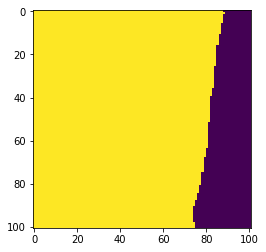

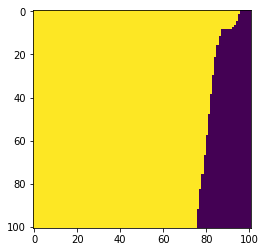

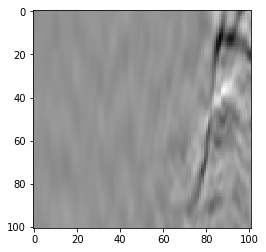

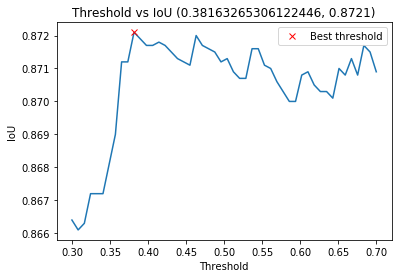

------------------------------ 1 -- 2 --------------------------------------------------


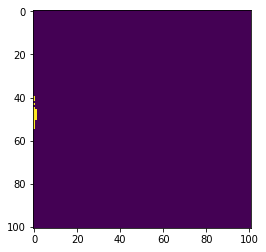

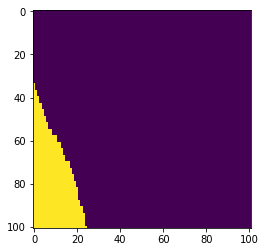

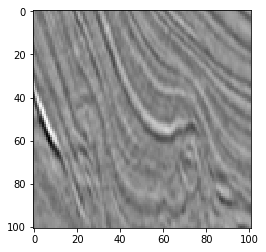

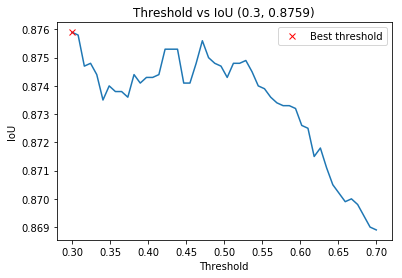

------------------------------ 2 -- 2 --------------------------------------------------


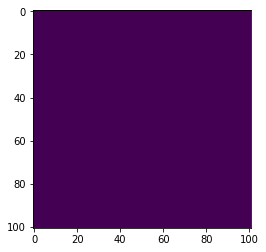

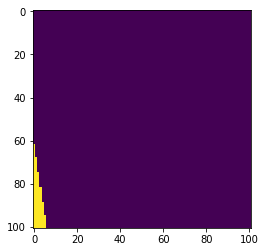

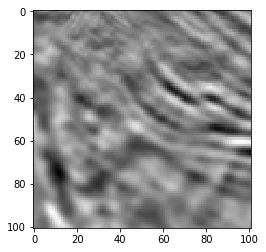

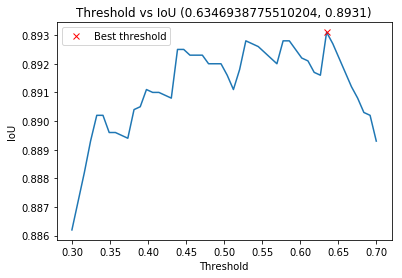

------------------------------ 3 -- 2 --------------------------------------------------


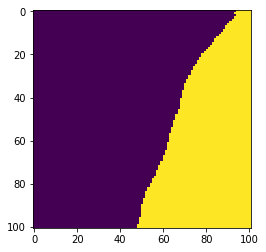

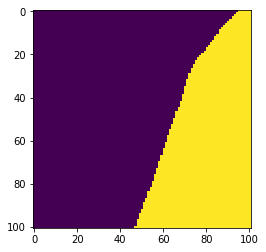

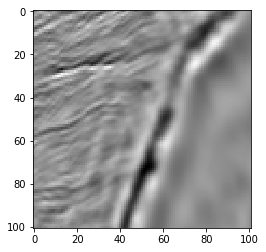

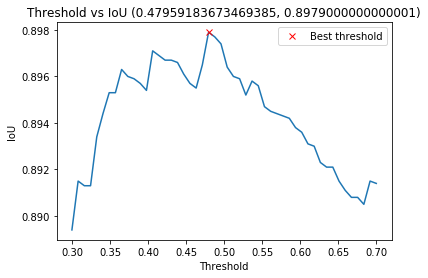

------------------------------ 0 -- 3 --------------------------------------------------


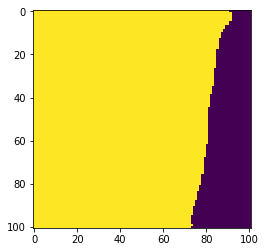

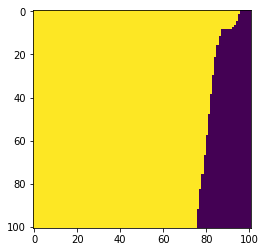

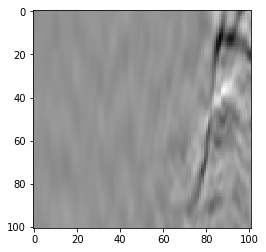

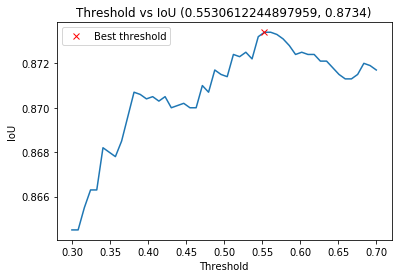

------------------------------ 1 -- 3 --------------------------------------------------


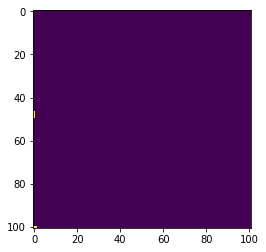

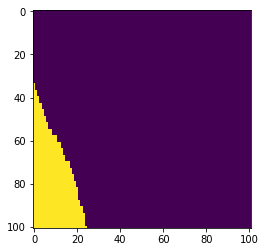

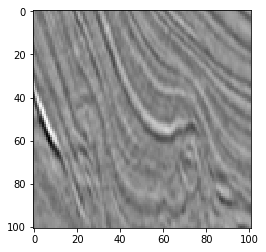

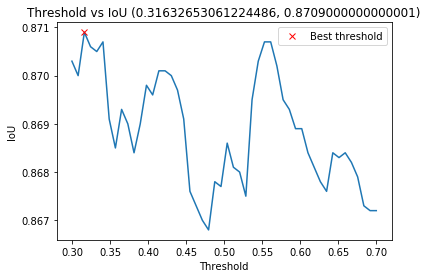

------------------------------ 2 -- 3 --------------------------------------------------


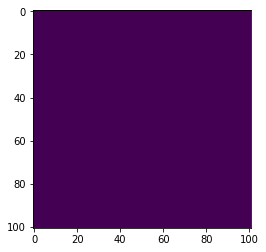

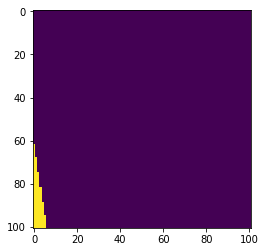

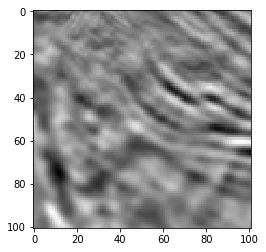

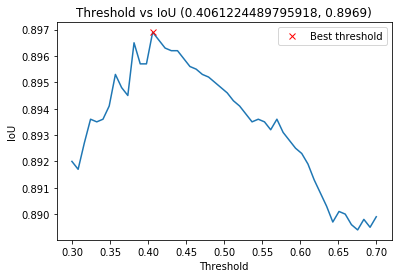

------------------------------ 3 -- 3 --------------------------------------------------


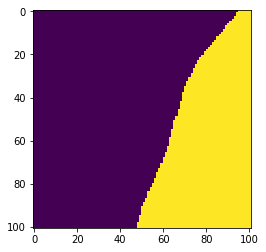

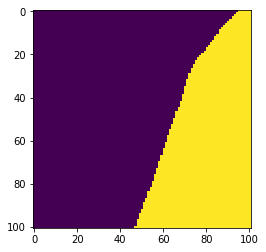

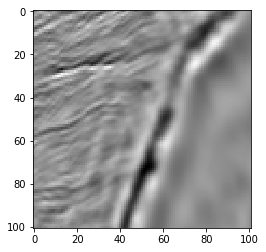

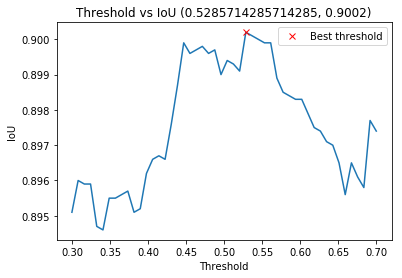

------------------------------ 0 -- 4 --------------------------------------------------


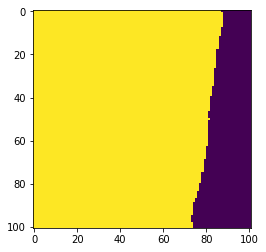

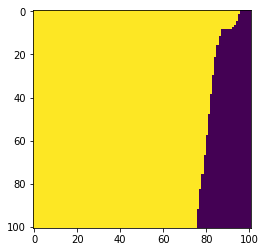

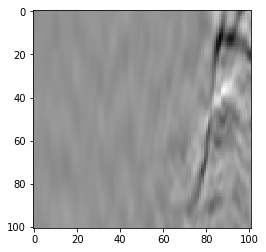

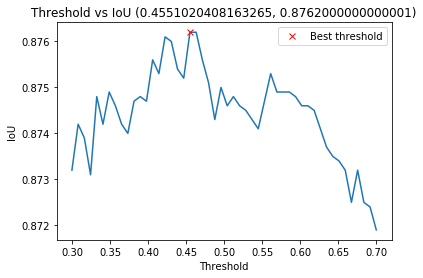

------------------------------ 1 -- 4 --------------------------------------------------


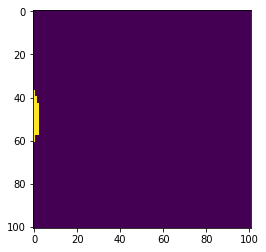

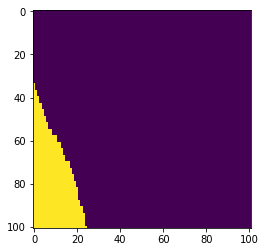

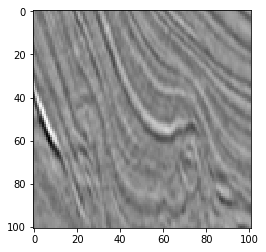

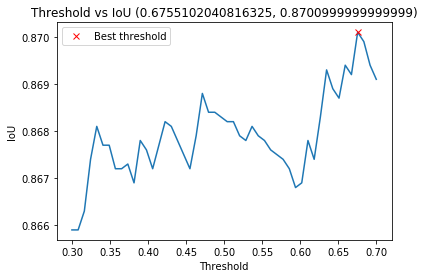

------------------------------ 2 -- 4 --------------------------------------------------


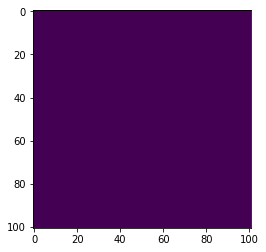

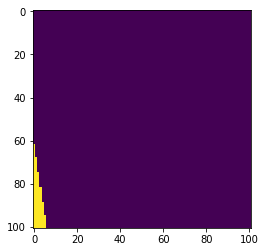

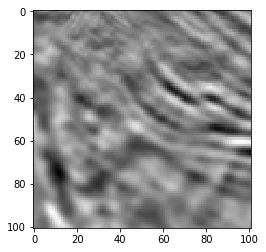

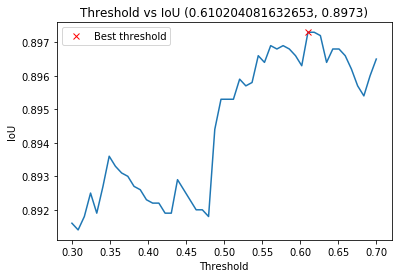

------------------------------ 3 -- 4 --------------------------------------------------


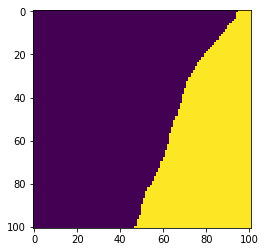

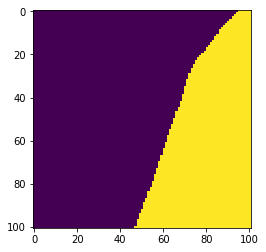

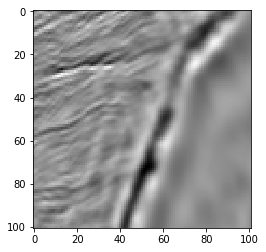

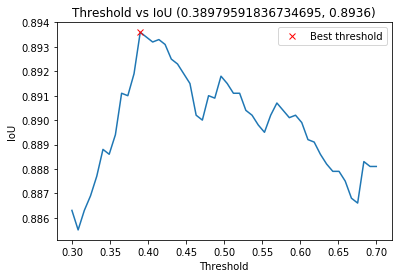

In [8]:
for part in range(2,5):
    for FOLDS in range(4):
        print('-'* 30, FOLDS,'--',part,'-'*50)
        load_mask = lambda im: cv2.imread(join(weg_train_mask, '{}.png'.format(im)))[:,:,0]
        fold = FOLDS
        preds = np.array([np.load(weg+'{}_model_weights_fold_{}/'.format(part,fold) + str(id_1)+'.npz')['arr_0']\
         for id_1 in test_ids[train_folds == fold]])

        #valid = np.array([np.expand_dims(load_mask(id_1),2) for id_1 in test_ids[train_folds == fold]])
        valid = np.array([load_mask(id_1) for id_1 in test_ids[train_folds == fold]])


        img_size_target = 101
        thresholds = np.linspace(0.3, .7, 50)

        from tqdm import tqdm_notebook
        ious = np.array([iou_metric(valid,\
                                    [img[:,:,0] for img in preds > threshold]) \
                         for threshold in tqdm_notebook(thresholds)])


        def weighted_dice_loss(y_true, y_pred, weight):
            smooth = 1.
            w, m1, m2 = weight, y_true, y_pred
            intersection = (m1 * m2)
            score = (2. * np.sum(w * intersection) + smooth) / (np.sum(w * m1) + np.sum(w * m2) + smooth)
            loss = 1. - np.sum(score)
            return loss

        plt.imshow(preds[151][:,:,0] > 0.65)
        plt.show()
        plt.imshow(valid[151] > 0.8)
        plt.show()
        plt.imshow(load_img(test_ids[train_folds == fold][151])[77:-78,77:-78,0],cmap='gray')
        plt.show()

        threshold_best_index = np.argmax(ious) 
        iou_best = ious[threshold_best_index]
        threshold_best = thresholds[threshold_best_index]

        plt.plot(thresholds, ious)
        plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
        plt.xlabel("Threshold")
        plt.ylabel("IoU")
        plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
        plt.legend()
        plt.show()
